<a href="https://colab.research.google.com/github/Tim-R413/Cover-Crop-Classification/blob/master/CC_classification_ORF_out.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Preparation:

In [0]:

% cd /content

#!pwd
!ls

/content
sample_data


# Cover Crop Classification using Tensorflow-Data Preprocessing and Model Framing 




 This is a Google Colab notebook containing the training code for a Machine Learning model of an image classfier created to identify species of cover crops both specific and mixtures. The following are categories that the model is trained to classify.

>Specific Species Categories: Canola, Clover, Triticale, Pea 
>Mixed species Categories:  



In [0]:
PIXEL_resolution = 16


##Setup:

In [0]:
# Tensorflow and tf.Keras APIs 
import tensorflow as tf 
from tensorflow import keras
from keras.layers import Dense, Conv2D, Flatten, Activation, Flatten, MaxPooling2D, Dropout,AveragePooling2D
print(tf.__version__)

1.14.0


Using TensorFlow backend.


In [0]:
# Supplementing/ helper Libraries 
import numpy as np 
import matplotlib.pyplot as plt 
import glob 
import os 
import re 
import math

# Python Image Library 
import PIL 
from PIL import Image

In [0]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

data is uploaded from google drive instead of github repository 




In [0]:
from google.colab import drive 
drive.mount('/content/gdrive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# !git clone   https://github.com/Tim-R413/Cover-Crop-Classification.git

#Loading in and Preprocessing the datasets 

##**Define** image preprocessing functions:

In [0]:
# Use Pillow library to convert an input jpeg to a 8 bit grey scale image array for processing.
def jpeg_to_8_bit_greyscale(path, photo_size):
        img = Image.open(path) #.convert('L')   # convert image to 8-bit grayscale
        # Make aspect ratio as 1:1, by applying image crop. this converts the images into sqaures

        Width, Height = img.size
        if Width != Height:
                m_min_d = min(Width, Height)
                img = img.crop((0, 0, m_min_d, m_min_d))
        # Scale the image to the requested max photo size by Anti-alias sampling.
        img.thumbnail(photo_size, PIL.Image.ANTIALIAS)
        return np.asarray(img)

In [0]:
# Define a function that loads dataset from images into numpy arrays (used for new instances/ testing data):

def load_image_dataset(dir_path, photo_size):
        images = []
        labels = []
        os.chdir(dir_path)
        for file in glob.glob("*.JPG"):
                img = jpeg_to_8_bit_greyscale(file, photo_size)
                if re.match('Canola*', file):
                        images.append(img)
                        labels.append(0)
                elif re.match('Clover*', file):
                        images.append(img)
                        labels.append(1)
                elif re.match('Triticale*', file):
                        images.append(img)
                        labels.append(2)
        for file in glob.glob("*.jpg"):
                img = jpeg_to_8_bit_greyscale(file, photo_size)
                if re.match('Canola*', file):
                        images.append(img)
                        labels.append(0)
                elif re.match('Clover*', file):
                        images.append(img)
                        labels.append(1)
                elif re.match('Triticale*', file):
                        images.append(img)
                        labels.append(2)
                
        return (np.asarray(images), np.asarray(labels))

###REVISED FUNCTIONS that divide images into 9 parts then fill the images and labels dataset arrays 

In [0]:


# define a function that crops each full image into 9 seperate size equivalent images  
def image_division (file_path, photo_size):
  full_img = Image.open(file_path) #.convert('L')
  
   # Make aspect ratio as 1:1, by applying image crop. this converts the images into sqaures
  Width, Height = full_img.size
  if Width != Height:
                m_min_d = min(Width, Height)
                full_img = full_img.crop((0, 0, m_min_d, m_min_d))
  
  # Splits the square image into 5 individual images, each cropped to 1/16 the size of the original image 
  # And Scales the image to the requested max photo size by Anti-alias sampling.
  DF = m_min_d
  DM = math.floor(DF / 4  )
  A = full_img.crop((0, 0, DM, DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  B = full_img.crop((DM,0,2*DM,DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  C = full_img.crop((2*DM,0,3*DM,DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  D = full_img.crop((3*DM,0,DF,DM)).resize(photo_size, PIL.Image.ANTIALIAS)

  E = full_img.crop((0,DM,DM,2*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  F = full_img.crop((DM,DM,2*DM,2*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  G = full_img.crop((2*DM,DM,3*DM,2*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  H = full_img.crop((3*DM,DM,DF,2*DM)).resize(photo_size, PIL.Image.ANTIALIAS)

  I = full_img.crop((0,2*DM,DM,3*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  J = full_img.crop((DM,2*DM,2*DM,3*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  K = full_img.crop((2*DM,2*DM,3*DM,3*DM)).resize(photo_size, PIL.Image.ANTIALIAS)
  L = full_img.crop((3*DM,2*DM,DF,3*DM)).resize(photo_size, PIL.Image.ANTIALIAS)

  M = full_img.crop((0,3*DM,DM,DF)).resize(photo_size, PIL.Image.ANTIALIAS)
  N = full_img.crop((DM,3*DM,2*DM,DF)).resize(photo_size, PIL.Image.ANTIALIAS)
  O = full_img.crop((2*DM,3*DM,3*DM,DF)).resize(photo_size, PIL.Image.ANTIALIAS)
  P = full_img.crop((3*DM,3*DM,DF,DF)).resize(photo_size, PIL.Image.ANTIALIAS)


    
  # returns each individual image as its own Numpy arra
  
  return np.asarray(A), np.asarray(B), np.asarray(C), np.asarray(D), np.asarray(E), np.asarray(F), np.asarray(G), np.asarray(H), np.asarray(I), np.asarray(J), np.asarray(K), np.asarray(L), np.asarray(M), np.asarray(N), np.asarray(O), np.asarray(P)

In [0]:
# define a function that maximizes the number of elemaets in a dataset by adding the cropped and scaled smaller images as their own peice of data 
def maximize_image_dataset (dir_path, photo_size):
  images = []
  labels=[]
  os.chdir(dir_path)
  
      # analyzes each image file in the designated folder and uses th eimage_division function to extract 5 seperate images from that larger image
  for file in glob.glob("*.JPG"):
    
        img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I, img_J, img_K, img_L, img_M, img_N, img_O, img_P= image_division(file, photo_size)
        img_set = [img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I, img_J, img_K, img_L, img_M, img_N, img_O, img_P]
        how_many = len(img_set)
          
        # appends each mini image to the 'images' dataset and appends its respecting index classification label to the 'label' dataset
        # images and labels are appended together so the index is kept consistent between the two datasets.  
        if  re.match('.*canola*', file):
                 for i in range (0,how_many):
                    images.append(img_set[i])
                    labels.append(0)
                               
        elif re.match('.*clover*', file):
                 for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(1)
                    
        elif re.match('.*triticale*', file):
                 for i in range (0,how_many):
                        images.append(img_set[i])
                        labels.append(2)
                  
        elif re.match('.*pea*', file) or re.match('.*Pea*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(3)
                  
        elif re.match('.*2Spp*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(4)
                  
        elif re.match('.*3SppN+', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(5)
                
        elif re.match('.*3SppM-*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(6)
                  
        elif re.match('.*5Spp*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(7)          
        
        elif re.match('.*6Spp*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(8)
                  
       # same as above section, was made to account for images with the lowercase '.jpg' extension         
  for file in glob.glob("*.jpg"):
    
        img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I, img_J, img_K, img_L, img_M, img_N, img_O, img_P= image_division (file, photo_size)
        img_set = [img_A, img_B, img_C, img_D, img_E, img_F, img_G, img_H, img_I, img_J, img_K, img_L, img_M, img_N, img_O, img_P]
        how_many = len(img_set)
          
        if re.match('.*canola*', file):
                 for i in range (0,how_many):
                    images.append(img_set[i])
                    labels.append(0)
                               
        elif re.match('.*clover*', file):
                 for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(1)
                    
        elif re.match('.*triticale*', file):
                 for i in range (0,how_many):
                        images.append(img_set[i])
                        labels.append(2)
                  
        elif re.match('.*pea*', file) or re.match('.*Pea*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(3)
                  
        elif re.match('.*2Spp*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(4)
                  
        elif re.match('.*3SppN+', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(5)
                
        elif re.match('.*3SppM-*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(6)
                  
        elif re.match('.*5Spp*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(7)          
        
        elif re.match('.*6Spp*', file):
                for i in range (0,how_many):
                       images.append(img_set[i])
                       labels.append(8)
                
  return (np.asarray(images), np.asarray(labels))

In [0]:
# Define a function that shuffles np arrays in unison to keep image and label index consistent:
def unison_shuffled_copies(I, L):
    assert len(I) == len(L)
    p = np.random.permutation(len(I))
    return I[p], L[p]

##Define image size and conduct dataset creation 

In [0]:
# image pixel resolution used to train and test model
a=PIXEL_resolution
photo_size= a, a
%cd /content

/content


 speciescategories or labels are indexed as following: 
Canola:0 
Clover:1 
Triticale:2 

*   Canola : 0
*   Clover : 1
* Triticale : 2
*Pea : 3
*2 spp : 4
*3 spp-N : 5
* 3 spp-M : 6
*5 spp : 7
*6 spp : 8





In [0]:


CATEGORIES = ['Canola', 'Clover', 'Triticale', 'Pea', '2 Spp' , '3 Spp-N', '3 Spp-M', '5 Spp', '6 Spp']
category_to_index = dict((name, index) for index,name in enumerate (CATEGORIES))
category_to_index


{'2 Spp': 4,
 '3 Spp-M': 6,
 '3 Spp-N': 5,
 '5 Spp': 7,
 '6 Spp': 8,
 'Canola': 0,
 'Clover': 1,
 'Pea': 3,
 'Triticale': 2}

In [0]:
## load training and test data into numpy aarrays by executing these functions: directory path is changed back to root before each function is executed:

(images, labels) = maximize_image_dataset('/content/gdrive/My Drive/Cover Crop species data /HALF SPECIES DATA',photo_size)


In [0]:
print(len(images))
print(len(labels))
print (images.shape)


2592
2592
(2592, 16, 16, 3)


In [0]:
unique, counts = np.unique(labels, return_counts=True)
dict(zip(unique, counts/16))

{0: 19.0,
 1: 18.0,
 2: 20.0,
 3: 13.0,
 4: 19.0,
 5: 19.0,
 6: 20.0,
 7: 14.0,
 8: 20.0}

randomly shuffle image and label data arrays, consistent with eachother. 

In [0]:
print('Original order of images/labels: \n' ,  labels)
images, labels = unison_shuffled_copies(images, labels)
print ()
print('Shuffled order of images/labels: \n' , labels)

Original order of images/labels: 
 [1 1 1 ... 7 7 7]

Shuffled order of images/labels: 
 [3 7 4 ... 7 7 1]


Seperate the full array of images and labels into 90% training data and 10% validation data 

In [0]:
## normalize the data
images=images/255.0


## Validating and displaying original datasets 

In [0]:
print(labels)

[3 7 4 ... 7 7 1]


In [0]:
def display_images(images, labels):
        plt.figure(figsize=(15,15))
        grid_size = min(16, len(images))
        for i in range(grid_size):
                plt.subplot(4, 4, i+1)
                plt.xticks([])
                plt.yticks([])
                plt.grid(False)
                plt.imshow(images[i], cmap=plt.cm.binary)
                plt.xlabel(CATEGORIES[labels[i]])

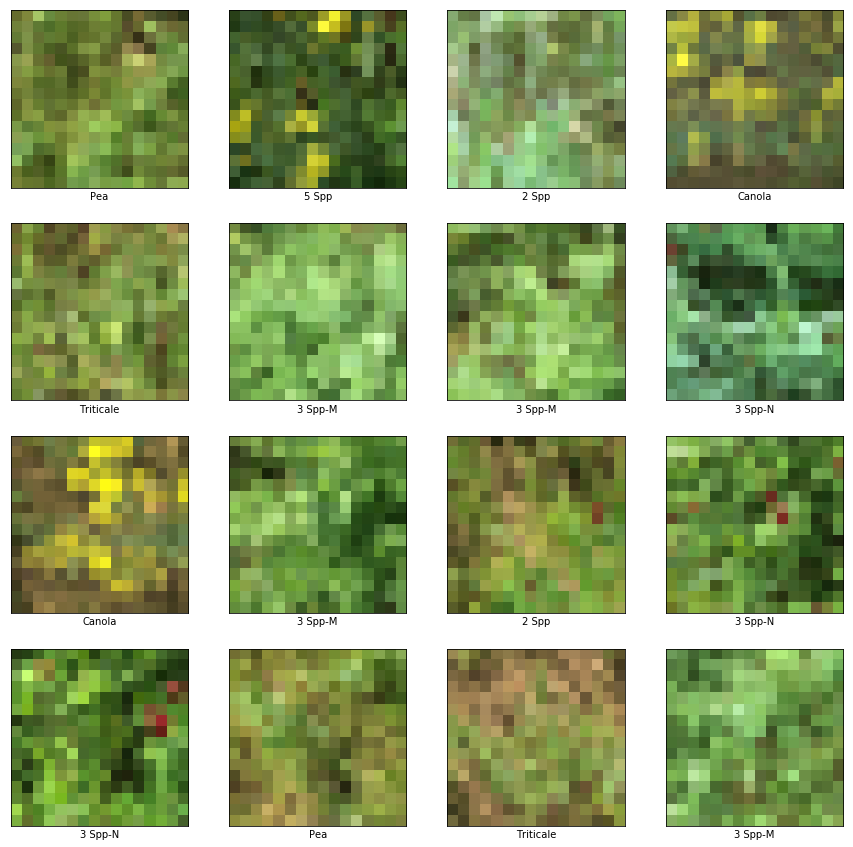

In [0]:
display_images(images, labels)
plt.show()

Text(0.5, 0, '2 Spp')

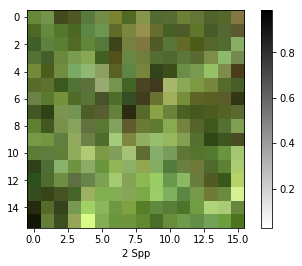

In [0]:
subtitle = 112
plt.figure()
plt.imshow(images[subtitle], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.xlabel(CATEGORIES[labels[subtitle]])

#Building the ML model:

**Initiialize the model layers:**

### Different model builds:

In [0]:
def my_newCNN(input_shape, num_classes):
  model= tf.keras.Sequential()
  
  model.add(keras.layers.Conv2D(filters=32, kernel_size=3,padding='same', activation= 'relu', input_shape=input_shape))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.25))
  
  model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.3))
  
  model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.5))
  
  
  model.add(keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.5))
  
  model.add(keras.layers.Flatten())

  
  model.add(keras.layers.Dense(128,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  

  
  model.add(keras.layers.Dense(num_classes, activation=tf.nn.sigmoid))
  
  return model

In [0]:
def my_VGG_CNN(input_shape, num_classes):
  model= tf.keras.Sequential()
  
  model.add(keras.layers.Conv2D(filters=32, kernel_size=3,padding='same', activation= 'relu', input_shape=input_shape))
    
  model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
  
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.5))
  
  model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
  
  model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
    
  model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
  
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.5))
  
  
  model.add(keras.layers.Conv2D(filters=32,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
  
  model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
    
  model.add(keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding='same', activation=tf.nn.relu))
  
  model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
  model.add(tf.keras.layers.Dropout(0.5))
  
  
  model.add(keras.layers.Flatten())
  model.add(keras.layers.Dense(128,activation=tf.nn.relu))
  model.add(tf.keras.layers.Dropout(0.5))
  model.add(keras.layers.Dense(num_classes, activation=tf.nn.sigmoid))
  
  return model

In [0]:

CCClassify_ORF_outIII = my_newCNN((a,a,3),9)
CCClassify_ORF_outIV = my_VGG_CNN((a,a,3),9)

**Compile the model:**

In [0]:

# which model will be tested 
run_model = CCClassify_ORF_outIV


In [0]:
run_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Training :

In [0]:
history=run_model.fit(images,labels, validation_split=0.10, batch_size= 64, shuffle=True, epochs =125)

### Plot Training Results:

In [0]:

plt.style.use('dark_background')
# Plot training & validation accuracy values
plt.plot(history.history['acc'],'y--',history.history['val_acc'],'r--')
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.grid()
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'],'y--',history.history['val_loss'],'r--')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.grid()
plt.show()

In [0]:
run_model.summary

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7f34018c6630>>

#Saving the Model(s)

In [0]:
#tf.keras.models.save_model(
   CCClassify_ORF_out,
  '/content/gdrive/My Drive/CCClassify_ORF_out',
   overwrite=True,
    include_optimizer=True,
    save_format=None
)

IndentationError: ignored